In [1]:
import pandas as pd
import numpy as np
import sparkge as sg
from sparkge import context as ctx
from sparkge import evolution as evo
from sparkge.evolution import length_of
from sparkge.providers.fitness import *
import warnings
%matplotlib inline
res = np.seterr(divide='ignore', invalid='ignore') #be careful
warnings.filterwarnings("ignore")
#set recusiion limit sparge.configure()

This notebook describes basic useage of sparkge. See the concepts notebook for a better understanding of the patterns used

# Grammar

In [2]:
from sparkge.symbols import *

def squared(x): return np.power(x,2)
def cubed (x): return np.power(x,3)

@terminal
def var():
    return ["X"]
    #return ["X", "A", "B", "C"]

@terminal
def param():
    #return ["X"]
    return [ "A", "B"]

@terminal(is_constant=True)
def const():return [ 2,3,4,5]#, np.pi

@operator()
def uop(): return [np.exp, np.log]#np.sin, np.cos , np.log, np.sin,

@operator()
def op(): return [add, sub, mul, truediv]#truediv

@operator()
def power(): return [np.power]

def expr(genome=None, args = []):  
    return as_expression(genome, [ op(expr,expr), power(expr,param) ,var, param])
    #return as_expression(genome,  [op(expr,expr),op(expr,expr),  var])

# Sample Expressions

In [3]:
power_sample = np.array([1,0,2])
power_law_sample = np.array([0,2,3,1, 1, 1,2])
#sample using a random genome - re-run cell to see other instances
f= expr(evo.chain(l=power_law_sample,max_wraps=2))#np.array([0,0,3,3])
print(f(X=3,A=4,B=6,C=5))
from sparkge.symbols import _repr_
print(_repr_(f))
S= display(f)
S

486
(B*(X**A))


   A
B⋅X 

## Get some sample data

In [4]:
df = pd.read_csv("./sparkge/data/asm_sample_data_duration.csv")
df.L = df.L.astype(int)
M = df[["L", "M1"]].set_index("L")
SAMPLE = M.sample(5000).sort_index()

# Fit the data to sample expression

B*X**A
Est params [ 0.97965119  0.30315913  1.        ]
GoF 0.221654250462


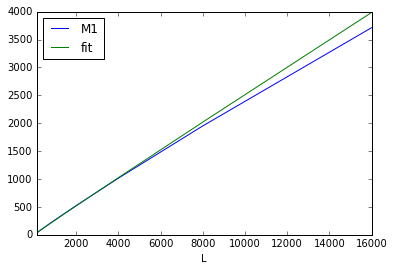

In [5]:
print(display(f))    
_f = accepting_ordered_params(f) #see comments in fnuction accepting_ordered_params
est = curve_fit(_f, SAMPLE, estimate=[[0.1,2,1,]], display=True)
print("Est params", est[0])
print("GoF", goodness_of_fit(_f,SAMPLE, est))

when fitting functions with scipy the convention is to pass the variables parameters in an ordered list f(X, params). To respect that we try to unravel our strict function of f(X=,A=,B=) into something that takes an ordered list. It is important of course to make sure that we map the right ordinal to the right key

# Strategy

In [6]:
s = evo.strategy(pop_size=100, genome_size=100, srate=0.52, mrate=0.01)

# Evolve a test function

In [ ]:
lengths, fitnesses, genes = s.init()
for generation in range(1000): 
    fitnesses = sg.symbols._evaluate(genes,expr)#default test function
    meta = np.stack([length_of(genes),fitnesses],axis=1)
    genes = s.select_and_mutate(meta,genes)
    sg.store.update(meta,genes)

# Curve fitting data


In [8]:
lengths, fitnesses, genes = s.init()
for generation in range(1000):   
    fitnesses = sg.symbols._evaluate_against_data(genes,expr,SAMPLE,p0=[[0.1, 2, 1, 1]]) 
    meta = np.stack([length_of(genes),fitnesses],axis=1)
    sg.store.update(meta,genes)
    genes = s.select_and_mutate(meta,genes)

# Spark

In [ ]:
#get a function that broadcasts the stuff and then gives back a function that can be sent to workers
def par_eval(pop):
    #ctx.sc
    #organise ids into mini mbatches and then remotely load data and eval each
    pass

lengths, fitnesses, genes = s.init()
for generation in range(1000):   
    fitnesses = par_eval(genes,expr) 
    meta = np.stack([length_of(genes),fitnesses],axis=1)
    store.update(meta,genes)
    genes = s.select_and_mutate(meta,genes)